## Convolutional Neural Network for classifying high content data
This script takes a small dataset from Kaggle and attempts to classify images according to whether the subjects were exposed to a candidate drug or not. Those that were typically display the 'dead' phonotype while those that were not display the 'alive' phonotype.

The dataset is too small to be used for practical purposes so this notebook is more of a demo of how convnets could be applied to larger datasets of this type. This model achieves very high accuracy but that is hardly impressive with a test size of just 40 images!

Note, this is currently not optimised for GPU acceleration and the image size is quite large so this is likely to take a while to run and may lock up the processor for a while.

## Read in images and extract image classes.
Credit to Kevin Mader for this section: https://www.kaggle.com/mholub/image-overview


In [1]:
import os
import numpy as np 
import pandas as pd 
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# load input images
all_tif_images=glob('C:\\Users\\alex.hall\Documents\\_git\\high-content-convnet\\BBBC010_v1_images\\*_w1_*.tif')
all_fg_images=glob('C:\\Users\\alex.hall\Documents\\_git\\high-content-convnet\\BBBC010_v1_foreground\\*.png')
# put input images paths into pandas DataFrame
image_df=pd.DataFrame([{'gfp_path': f} for f in all_tif_images])

image_df.iloc[1,0]

'C:\\Users\\alex.hall\\Documents\\_git\\high-content-convnet\\BBBC010_v1_images\\1649_1109_0003_Amp5-1_B_20070424_A02_w1_773004B9-5D0A-4322-AFC2-CF6D9D5068A9.tif'

In [3]:
# define mapping function
def _get_light_path(in_path):
    w2_path='_w2_'.join(in_path.split('_w1_'))
    glob_str='_'.join(w2_path.split('_')[:-1]+['*.tif'])
    m_files=glob(glob_str)
    if len(m_files)>0:
        return m_files[0]
    else:
        return None
# create new columns with yet another paths
image_df['light_path']=image_df['gfp_path'].map(_get_light_path)
image_df=image_df.dropna()
image_df['base_name']=image_df['gfp_path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])

image_df['base_name'][1]

'1649_1109_0003_Amp5-1_B_20070424_A02_w1_773004B9-5D0A-4322-AFC2-CF6D9D5068A9'

In [4]:
# Extract data from the image name

# clearly this is not the case
# <plate>_<wellrow>_<wellcolumn>_<wavelength>_<fileid>.tif
# Columns 1-12 are positive controls treated with ampicillin. Columns 13-24 are untreated negative controls.
# we apply a new rule
# 1649_1109_0003_Amp5-1_B_20070424_A01_w1_9E84F49F-1B25-4E7E-8040-D1BB2D7E73EA.tif
# junk_junk_junk_junk_junk_date_RowCol_wavelength_id.tif

image_df['plate_rc']=image_df['base_name'].map(lambda x: x.split('_')[6])
image_df['row']=image_df['plate_rc'].map(lambda x: x[0:1])
image_df['column']=image_df['plate_rc'].map(lambda x: int(x[1:]))
image_df['treated']=image_df['column'].map(lambda x: x<13)
image_df['wavelength']=image_df['base_name'].map(lambda x: x.split('_')[7])

image_df['mask_path']=image_df['plate_rc'].map(lambda x: '../input/BBBC010_v1_foreground/{}_binary.png'.format(x))
print('Loaded',image_df.shape[0],'datasets')
# pd.df.sample - Returns a random sample of items from an axis of object.
image_df.sample(3)

Loaded 97 datasets


,gfp_path,light_path,base_name,plate_rc,row,column,treated,wavelength,mask_path
45,C:\Users\alex.hall\Documents\_git\high-content...,C:\Users\alex.hall\Documents\_git\high-content...,1649_1109_0003_Amp5-1_B_20070424_B22_w1_81E0BD...,B22,B,22,False,w1,../input/BBBC010_v1_foreground/B22_binary.png
3,C:\Users\alex.hall\Documents\_git\high-content...,C:\Users\alex.hall\Documents\_git\high-content...,1649_1109_0003_Amp5-1_B_20070424_A04_w1_627EA5...,A04,A,4,True,w1,../input/BBBC010_v1_foreground/A04_binary.png
29,C:\Users\alex.hall\Documents\_git\high-content...,C:\Users\alex.hall\Documents\_git\high-content...,1649_1109_0003_Amp5-1_B_20070424_B06_w1_0D4BEF...,B06,B,6,True,w1,../input/BBBC010_v1_foreground/B06_binary.png


## Import images and process.
For now, we're just using the GFP channel

(520, 696)


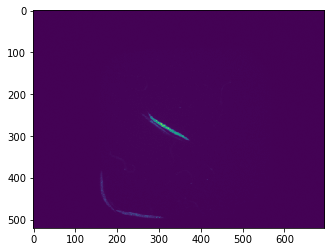

In [5]:
%matplotlib inline
test_image_row=list(image_df.query('treated').sample(1).T.to_dict().values())[0]
test_img=Image.open(test_image_row['gfp_path'])
test_img_array=np.array(test_img)
print(np.shape(test_img_array))
plt.imshow(test_img)

Now import all the GFP channel images and save as a list of numpy arrays
Split into a train and test set and save corresponding labels

In [6]:
x_train=list()
y_train=list()
for i in range(0,int(np.shape(image_df)[0]*0.7)):
    x_train.append(np.array(Image.open(image_df.iloc[i]['gfp_path'])))
    y_train.append(int(image_df.iloc[i]['treated']))
    
x_test=list()
y_test=list()
for i in range(int(np.shape(image_df)[0]*0.7),np.shape(image_df)[0]):
    x_test.append(np.array(Image.open(image_df.iloc[i]['gfp_path'])))
    y_test.append(int(image_df.iloc[i]['treated']))
    


In [7]:
x_train=np.array(x_train)
x_test=np.array(x_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

## Make helper functions to assist with data transformation

In [8]:
#we want to one-hot encode the results
def one_hot_encode(vec, vals=2):
    '''
    For use to one-hot encode the 2 possible labels
    '''
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

In [9]:
y_train = one_hot_encode(y_train, 2)
y_test = one_hot_encode(y_test,2)

## Create Model

In [10]:
import tensorflow as tf
x = tf.placeholder(tf.float32,shape=[None,520,696])
y_true = tf.placeholder(tf.float32,shape=[None,2])
dropprob = tf.placeholder(tf.float32) #used for dropout

Helper functions for building the model

In [11]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

# Creating CNN layers
Building up a network by creating convolutional and pooling layers. The number and size of these layers would be tuned to find optimal values if we were carrying out a more detailed analysis.

In [12]:
x_image = tf.reshape(x,[-1,696,520,1])

convo_1 = convolutional_layer(x_image,shape=[10,10,1,32])
convo_1_pooling = max_pool_2by2(convo_1)

convo_2 = convolutional_layer(convo_1_pooling,shape=[6,6,32,64])
convo_2_pooling = max_pool_2by2(convo_2)

#  pooling layers, so (696/2)/2 = 174 . 520/2/2 = 130. Note, we would need far more conv layers in a real
#life application but this would require a lot of runtime
# 64 then just comes from the output of the previous Convolution
convo_2_flat = tf.reshape(convo_2_pooling,[-1,130*174*64])
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat,1024))

#placeholders for dropout
hold_prob = tf.placeholder(tf.float32)
full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)

#output layer
y_pred = normal_full_layer(full_one_dropout,2)

# Loss function and optimiser

In [13]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred))
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
train = optimizer.minimize(cross_entropy)

# Run Session

In [14]:
import random
init = tf.global_variables_initializer()

steps = 100

with tf.Session() as sess:
    
    sess.run(init)
    
    for i in range(steps):
        batch_indices=random.sample(range(0,np.shape(x_train)[0]), 10)
        batch_x  = x_train[batch_indices]
        batch_y = y_train[batch_indices]
        
        sess.run(train,feed_dict={x:batch_x,y_true:batch_y,hold_prob:0.5})
        
        # PRINT OUT A MESSAGE EVERY 100 STEPS
        if i%1 == 0:
            
            print('Currently on step {}'.format(i))
            print('Accuracy is:')
            # Test the Train Model
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            print(sess.run(acc,feed_dict={x:x_test,y_true:y_test,hold_prob:1.0}))
            print('\n')

Currently on step 0
Accuracy is:
0.533333


Currently on step 1
Accuracy is:
0.533333


Currently on step 2
Accuracy is:
0.466667


Currently on step 3
Accuracy is:
0.466667


Currently on step 4
Accuracy is:
0.466667


Currently on step 5
Accuracy is:
0.466667


Currently on step 6
Accuracy is:
0.466667


Currently on step 7
Accuracy is:
0.933333


Currently on step 8
Accuracy is:
0.9


Currently on step 9
Accuracy is:
0.8


Currently on step 10
Accuracy is:
0.666667


Currently on step 11
Accuracy is:
0.666667


Currently on step 12
Accuracy is:
0.8


Currently on step 13
Accuracy is:
0.833333


Currently on step 14
Accuracy is:
1.0


Currently on step 15
Accuracy is:
1.0


Currently on step 16
Accuracy is:
1.0


Currently on step 17
Accuracy is:
1.0


Currently on step 18
Accuracy is:
0.966667


Currently on step 19
Accuracy is:
0.866667


Currently on step 20
Accuracy is:
0.833333


Currently on step 21
Accuracy is:
0.833333


Currently on step 22
Accuracy is:
0.866667


Currently 

So, this model achieved 100% accuracy on the test set (ie it can identify all the samples that were exposed to the compound through use of the GFP channel alone.)
However this is not very impressive due to the small sample size. Such a small dataset didn't allow for a proper validation set so it is likely the model has been overfitted too.